# Flipped Digits Error

This notebook is a quick analysis (with commented code!) of deep learnings ability to find flipped digits errors in an income distribution. The income distribution will be simulated with a log-normal distribution.

## Libraries

In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import tensorflow_probability as tfp
from tensorflow import keras

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.10.1
Eager execution: True


In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Boilerplate (Fake Data Creation)

In [3]:
def flipped_digits(mu=np.log(25), sigma=np.log(10)/3, n=int(1e5), error_rate=0.1, data=None):
    """Flipped value of digits that are next to each other."""
    if data is None:
        true_value = np.random.lognormal(mu, sigma, n)
    else:
        true_value = data
        n = len(true_value)

    true_value = [round(i, 6) for i in true_value]
    error = np.random.binomial(1, error_rate, size=n)
    observed = np.zeros(n)
    # Note that there are several cases for pivots. Pivots at extremes of a number have only one
    # possible direction to pivot. While pivots in the middle of number have two possible directions.
    # Similarly need to check if the pivot has repeated numbers next to it as this negates the error. (TODO)
    for i in range(n):
        if error[i] == 1:
            num = true_value[i]
            length_of_number = int(np.log10(num))+6
            num = num*1e7 # To avoid decimal point in flipping
            pivot = np.random.randint(0,length_of_number+1)
            
            # Right most digit
            if pivot == length_of_number:
                # Check for repeated digit
                if str(num)[pivot] == str(num)[pivot-1]:
                    observed[i] = true_value[i]
                    error[i] = 0
                else:
                    observed[i] = float(str(num)[:pivot-2] + str(num)[pivot-1] +
                                        str(num)[pivot-2] + str(num)[pivot:])/(1e7)
            
            # Left most digit
            elif pivot == 0:
                # Check for repeated digit
                if str(num)[pivot] == str(num)[pivot+1]:
                    observed[i] = true_value[i]
                    error[i] = 0
                else:
                    observed[i] = float(str(num)[1] + str(num)[0] + str(num)[2:])/(1e7)

            # Middle digits
            else:
                # Right swap
                if np.random.binomial(1, .5, 1):
                    # Check for repeated digit
                    if str(num)[pivot] == str(num)[pivot+1]:
                        observed[i] = true_value[i]
                        error[i] = 0
                    else:
                        observed[i] = float(str(num)[:pivot] + str(num)[pivot+1] +
                                        str(num)[pivot] + str(num)[pivot+2:])/(1e7)
                # Left swap
                else:
                    # Check for repeated digit
                    if str(num)[pivot] == str(num)[pivot-1]:
                        observed[i] = true_value[i]
                        error[i] = 0
                    else:
                        observed[i] = float(str(num)[:pivot-1] + str(num)[pivot] +
                                        str(num)[pivot-1] + str(num)[pivot+1:])/(1e7)
        else:
            observed[i] = true_value[i]
    data = {"error" : error, "observed" : observed, "true_value" : true_value}
    return pd.DataFrame(data=data)

## Introduction

We sample from a log-normal distribution and add an error to simulate someone flipping two digits in an entry. It is very difficult to detect the error visually from looking at the distributions even when most of the distribution has this type of error. However, one can see a jaggedness that is developing between each tens digit. It is unlikely to separate this error from truncation error from binning.

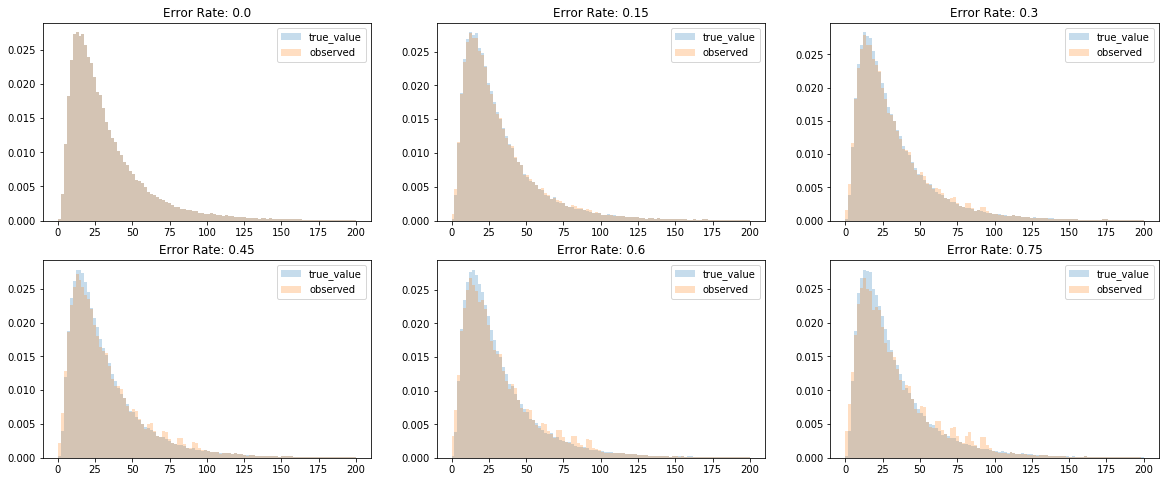

In [4]:
df = [flipped_digits(mu=np.log(25), sigma=np.log(10)/3, n=int(1e5), error_rate=i) for i in np.arange(0, 1, 0.15)]

fig, axs = plt.subplots(2,3, figsize=(20,8), facecolor='w', edgecolor='k')

for ax, i in zip(axs.ravel(), range(0,6)):
        ax.hist(df[i]["true_value"], bins=100, alpha=0.25, range=[0,200], density=True)
        ax.hist(df[i]["observed"], bins=100, alpha=0.25, range=[0,200], density=True)
        ax.legend()
        ax.set_title("Error Rate: " + str(round(i*0.15, 2)))
plt.show()

## Modeling

In [5]:
train, test = train_test_split(df[1], test_size=0.25)
test_len = len(test)
X_train = np.array(train["observed"]).reshape(-1, 1)
y_train = np.array(train["error"])
X_test = np.array(test["observed"]).reshape(-1, 1)
y_test = np.array(test["error"])

In [6]:
def build_model():
    model = keras.Sequential([
    keras.layers.Dense(20, activation=tf.nn.relu, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
  ])
    model.compile(optimizer=tf.train.AdamOptimizer(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', keras.metrics.categorical_accuracy])
    return model

model = build_model()

In [7]:
# Print evidence of each epoch ending in readable format
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print('.', end='')

history = model.fit(X_train, y_train, epochs=100,
                    validation_split=0.25, verbose=0,
                    validation_data=(X_test, y_test),
                    callbacks=[PrintDot()])


...

KeyboardInterrupt: 

In [ ]:
history.history['acc']